In [66]:
%matplotlib inline
import pandas as pd
import scipy as sp
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

In [2]:
country_enc = LabelEncoder()
source_enc = LabelEncoder()
df = pd.DataFrame.from_csv('conversion_data.csv')
df.reset_index(inplace=True)
data_frame = df.copy()
df['country'] = country_enc.fit_transform(df.country)
df['source'] = country_enc.fit_transform(df.source)
df[1:5]

,country,age,new_user,source,total_pages_visited,converted
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


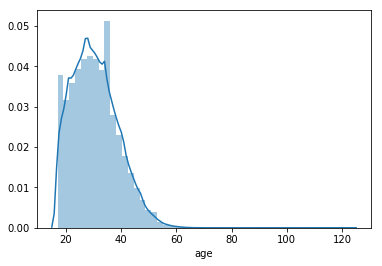

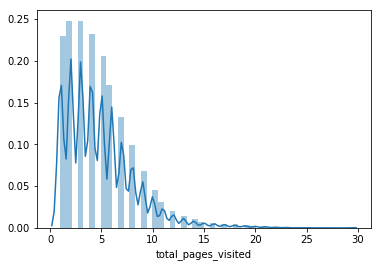

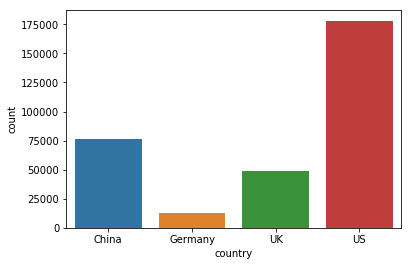

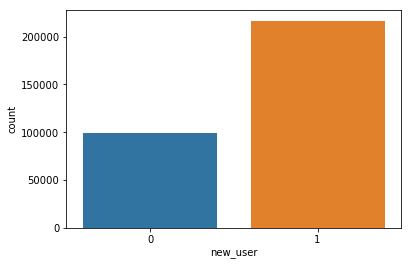

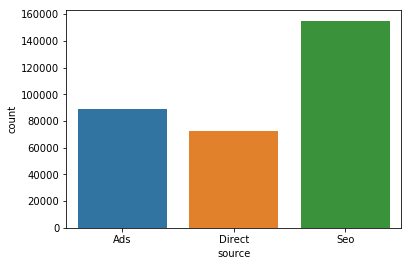

In [3]:
sn.distplot(a=df.age)
plt.show()
sn.distplot(a=df.total_pages_visited)
plt.show()
sn.barplot(x='country', y='count', data=data_frame.groupby('country').count()[['age']].rename(columns={'age':'count'}).reset_index())
plt.show()
sn.barplot(x='new_user', y='count', data=data_frame.groupby('new_user').count()[['age']].rename(columns={'age':'count'}).reset_index())
plt.show()
sn.barplot(x='source', y='count', data=data_frame.groupby('source').count()[['age']].rename(columns={'age':'count'}).reset_index())
plt.show()

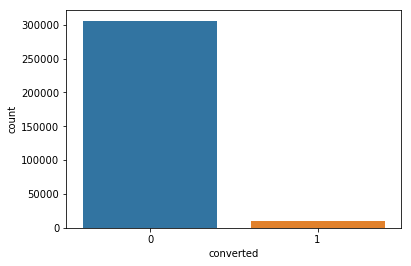

conv rate:  0.0322580645161


,group,group_count,rate,converted
0,nonconverted,306000,0.967742,0
1,converted,10200,0.032258,1


In [21]:
sn.barplot(x='converted', y='count', data=data_frame.groupby('converted').count()[['age']].rename(columns={'age':'count'}).reset_index())
plt.show()
convbool = df.converted == 1
converted = sum(convbool)
non_converted = sum(~convbool)
sessions = len(convbool)
conv_rate = converted / sessions
print("conv rate: ", conv_rate)
stats_df = pd.DataFrame()
stats_df['group'] = ['nonconverted', 'converted']
stats_df['group_count'] = [non_converted, converted]
stats_df['rate'] = stats_df['group_count'] / sessions
stats_df['converted'] = [0, 1]
stats_df

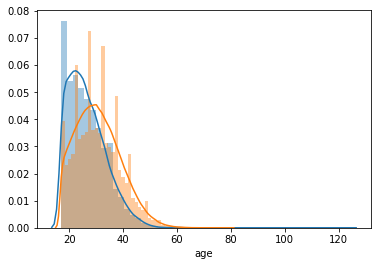

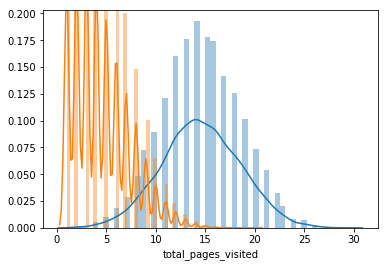

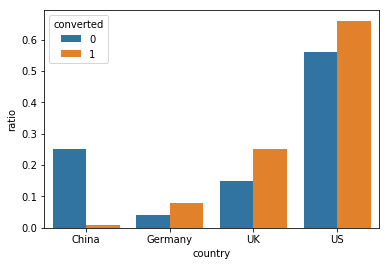

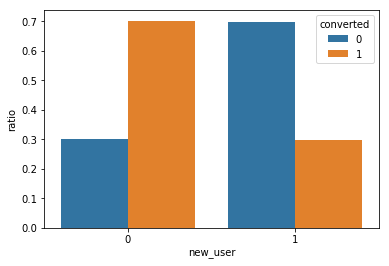

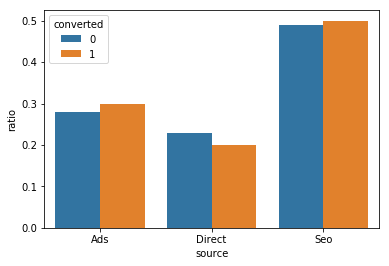

In [22]:
conv_df = data_frame.where(data_frame.converted == 1).dropna(how='all')
nonconv_df = data_frame.where(data_frame.converted == 0).dropna(how='all')
sn.distplot(a=conv_df.age)
sn.distplot(a=nonconv_df.age)
plt.show()
sn.distplot(a=conv_df.total_pages_visited)
sn.distplot(a=nonconv_df.total_pages_visited)
plt.show()
def plot_for_column(colname):
    plotdf = data_frame.groupby(['converted', colname]).count()[['age']].rename(columns={'age':'count'}).reset_index().merge(stats_df[['converted', 'group_count']], on='converted')
    plotdf['ratio'] = plotdf['count'] / plotdf['group_count']
    sn.barplot(x=colname, y='ratio', data=plotdf, hue='converted')
    plt.show()
plot_for_column('country')
plot_for_column('new_user')
plot_for_column('source')

In [10]:
from sklearn.model_selection import train_test_split
X, Y = df[['country', 'age', 'new_user', 'source', 'total_pages_visited']], df[['converted']]
x_test, x_train, y_test, y_train = train_test_split(X, Y, test_size=0.8, train_size=0.2)

In [78]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

sgd = SGDClassifier(alpha=1e-4, max_iter=9000, tol=1e-6, loss='log')
mnb = MultinomialNB(alpha=1e-4)
mlp = MLPClassifier(hidden_layer_sizes=(32,32,16,8), activation='tanh')
rfor = RandomForestClassifier(n_estimators=50, n_jobs=-1)

def try_model(clf):
    clf.fit(x_train, y_train.converted)
    train_preds = clf.predict(x_train)
    test_preds = clf.predict(x_test)
    print(classification_report(y_train, train_preds))
    print(classification_report(y_test, test_preds))
    
def try_model_get_proba(clf):
    try_model(clf)
    return clf.predict_proba(x_train), clf.predict_proba(x_test)

print("SGD")
sgd_train_prob, sgd_test_prob = try_model_get_proba(sgd)
print("MNB")
mnb_train_prob, mnb_test_prob = try_model_get_proba(mnb)
print("MLP")
mlp_train_prob, mlp_test_prob = try_model_get_proba(mlp)
print("Rand Forest")
rfor_train_prob, rfor_test_prob = try_model_get_proba(rfor)

SGD
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    244809
          1       0.73      0.69      0.71      8151

avg / total       0.98      0.98      0.98    252960

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     61191
          1       0.75      0.70      0.72      2049

avg / total       0.98      0.98      0.98     63240

MNB
             precision    recall  f1-score   support

          0       0.99      0.98      0.99    244809
          1       0.58      0.79      0.67      8151

avg / total       0.98      0.97      0.98    252960

             precision    recall  f1-score   support

          0       0.99      0.98      0.99     61191
          1       0.58      0.79      0.67      2049

avg / total       0.98      0.97      0.98     63240

MLP
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    244809
          1       0.8

In [79]:
from sklearn.preprocessing import LabelBinarizer
prob_enc = LabelBinarizer().fit(y=[0,1])
# prob_enc.inverse_transform(np.asarray([[0.2,0.8]]))

In [80]:
comb_train_prob = (sgd_train_prob + mlp_train_prob + mnb_train_prob + rfor_train_prob)/4
comb_test_prob = (sgd_test_prob + mlp_test_prob + mnb_test_prob + rfor_test_prob)/4

In [95]:
train_prob_sum = sum(comb_train_prob)
test_prob_sum = sum(comb_test_prob)
print('train_rate: ', train_prob_sum[1]/sum(train_prob_sum))
print('test_rate: ', train_prob_sum[1]/sum(train_prob_sum))
print('measured_rate: ', stats_df['rate'][1])

train_rate:  0.0359495020917
test_rate:  0.0359495020917
measured_rate:  0.0322580645161


In [81]:
comb_train_preds = prob_enc.inverse_transform(comb_train_prob)
comb_test_preds = prob_enc.inverse_transform(comb_test_prob)

In [82]:
print(classification_report(y_train, comb_train_preds))
print(classification_report(y_test, comb_test_preds))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    244809
          1       0.83      0.72      0.77      8151

avg / total       0.99      0.99      0.99    252960

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     61191
          1       0.82      0.71      0.76      2049

avg / total       0.98      0.99      0.98     63240



In [84]:
from sklearn.metrics import confusion_matrix
# sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
train_confmat = confusion_matrix(y_train, comb_train_preds)
test_confmat = confusion_matrix(y_test, comb_test_preds)

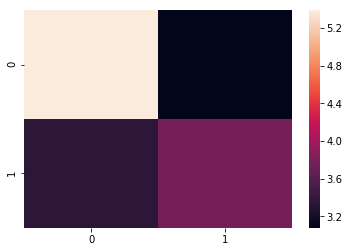

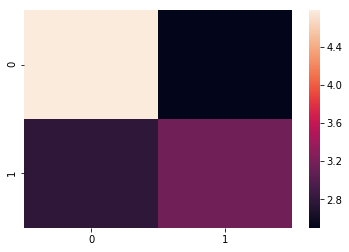

In [89]:
sn.heatmap(data=np.log10(train_confmat))
plt.show()
sn.heatmap(data=np.log10(test_confmat))
plt.show()

In [90]:
from sklearn.linear_model import SGDRegressor